# Orchestrator-worker

In an orchestrator-worker configuration, the orchestrator:

## Breaks down tasks into subtasks
## Delegates subtasks to workers
## Synthesizes worker outputs into a final result


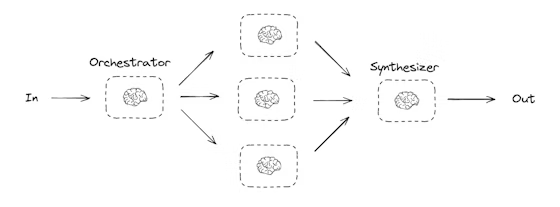

Orchestrator-worker workflows provide more flexibility and are often used when subtasks cannot be predefined the way they can with parallelization.

This is common with workflows that write code or need to update content across multiple files.

For example, a workflow that needs to update installation instructions for multiple Python libraries across an unknown number of documents might use this pattern.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai

In [6]:
import os
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini")

In [7]:
from typing import Annotated, List
import operator

# Schema for structured output
from pydantic import BaseModel, Field

# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

## Creating workers in LangGraph

Orchestrator-worker workflows are common and LangGraph has built-in support for them.
The **Send** API lets you dynamically create worker nodes and send them specific inputs.

Each worker has its own state, and all worker outputs are written to a shared state key that is accessible to the orchestrator graph.
This gives the orchestrator access to all worker output and allows it to synthesize them into a final output.
The example below iterates over a list of sections and uses the Send API to send a section to each worker.

In [9]:
from langgraph.types import Send

# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]


In [15]:
from langchain_core.messages import SystemMessage, HumanMessage

# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


In [11]:
# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


## Build the Workflow with StateGraph

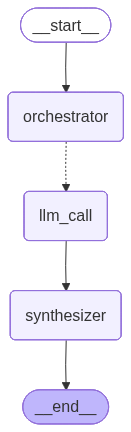

In [13]:
from langgraph.graph import START, StateGraph, END
from IPython.display import Image, display

# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))


In [16]:
# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})


In [18]:
# Output of the Orchestrator/Planner
state["sections"]

[Section(name='Introduction to LLM Scaling Laws', description='An overview of what large language models (LLMs) are and the significance of scaling laws in their development.'),
 Section(name='Theoretical Foundations of Scaling Laws', description='Discussion of the mathematical and theoretical principles that underpin scaling laws for LLMs, including previous research and findings.'),
 Section(name='Empirical Evidence of Scaling Laws', description='Analysis of experimental data collected from various LLMs, showcasing how performance varies with increased model size, training data, and computational resources.'),
 Section(name='Key Factors Influencing Scaling Laws', description='Examination of critical parameters such as architecture, training objectives, and data quality that impact the scaling behavior of LLMs.'),
 Section(name='Implications for Model Development', description='Insights on how understanding scaling laws can guide the design and deployment of future LLMs for improved p

In [17]:
# Each section is generated by a different LLM call in parallel with others
from IPython.display import Markdown
Markdown(state["final_report"])

## Introduction to LLM Scaling Laws

Large Language Models (LLMs) are advanced artificial intelligence systems designed to understand and generate human-like text. They are built using deep learning techniques, specifically leveraging architectures such as transformers. LLMs are trained on vast amounts of text data, enabling them to perform various tasks ranging from language translation and summarization to question answering and conversational agents. The effectiveness of these models largely hinges on their ability to grasp context, sentiments, and nuances in language, which is achieved through their deep learning frameworks.

Scaling laws play a pivotal role in the development of LLMs, offering insights into how model performance improves with increasing data and computational resources. Through extensive research, it has been established that as the size of the model increases—be it in the number of parameters, the volume of training data, or the computational power applied—there is a predictable enhancement in the model's performance metrics. This relationship underscores the significance of resource allocation and provides a roadmap for researchers and practitioners to optimize the effectiveness of LLMs.

Understanding scaling laws allows developers to make informed decisions regarding the design and deployment of LLMs. By identifying the thresholds where performance gains become marginal, it guides the investment of resources in model development to achieve the best results. The exploration of these laws has significant implications not just for enhancing current models but also for shaping the future of AI technologies, especially in the quest for more powerful and efficient language processing capabilities.

---

## Theoretical Foundations of Scaling Laws

Scaling laws for Large Language Models (LLMs) are grounded in several mathematical and theoretical principles that elucidate the relationship between model size, data quantity, and performance. At the core of these principles is the observation that as the scale of models and datasets increases, performance improvements tend to follow predictable patterns, often approximated by power laws.

### Mathematical Framework

1. **Power Law Distribution**: Scaling relationships often exhibit a power law form, where performance metrics \(P\) can be expressed as:

   \[
   P \propto N^{\alpha}
   \]

   Here, \(N\) represents the number of parameters or the size of the dataset, and \(\alpha\) is a scaling exponent that characterizes the relationship. Many studies have shown that better performance can be achieved with larger models and more data, leading to converging performance limits.

2. **Logarithmic Scaling**: Certain scaling behaviors can also be described through logarithmic relationships, where improvements in performance may diminish as a function of resource investment:

   \[
   P = C \cdot \log(N) + b
   \]

   This often reflects diminishing returns as models approach the asymptotic performance limits dictated by their architecture and the richness of the training data.

### Theoretical Insights

1. **Capacity Theory**: The capacity of a model indicates its ability to store and represent information. Research highlights that larger models possess greater capacity, enabling them to learn more complex patterns and relationships in data. This theory is supported by studies correlating parameters and the model's ability to generalize on unseen data.

2. **Information Theory**: The principles of information theory emphasize the importance of data quality and diversity alongside sheer volume. Shannon's entropy informs us that models trained on more informative distributions of data can outperform those with larger but redundant information. Scaling laws, in this context, illustrate the balance of quantity versus quality in training data.

3. **Statistical Learning Theory**: This theory provides insight into how scaling impacts generalization. Increased model capacity allows for a better fit of training data, but training on larger datasets assists in mitigating overfitting, thus enhancing generalization performance as model size scales.

### Previous Research and Findings

The exploration of scaling laws emerged prominently in works like the paper by Kaplan et al. (2020), which empirically observed that performance on language tasks improved in predictable ways as model size increased. This study outlined the "Scaling Laws for Neural Language Models" and introduced benchmarks that help validate the theoretical underpinnings. Subsequent research has built upon these foundational insights, confirming scaling trends across various architectures and tasks (e.g., autoregressive models and Transformer architectures).

More recently, research by Brown et al. (2020) in the "Language Models are Few-Shot Learners" paper demonstrated the effectiveness of large models with few-shot learning capabilities, further confirming the scaling relationships through their exploratory experiments with the GPT-3 model. Further investigations highlighted that optimal performance requires both an increase in model size and access to extensive, diverse datasets, reinforcing the necessity of considering both dimensions in future model designs.

In summary, the theoretical foundations of scaling laws provide a framework to anticipate LLM performance improvements, paving the way for advancements in model architecture and training methodologies. Understanding these principles remains vital for researchers and practitioners aiming to leverage LLMs effectively in real-world applications.

---

## Empirical Evidence of Scaling Laws

The examination of large language models (LLMs) has led to significant insights into their performance dynamics in relation to model size, training data, and computational resources. Various studies have documented consistent scaling laws that dictate how these models behave as they are scaled upwards.

### Model Size

Empirical evidence consistently indicates that larger models generally outperform their smaller counterparts across a variety of benchmarks. For instance, the performance on natural language understanding tasks tends to demonstrate a logarithmic relationship with the number of parameters. This trend implies that while initial increments in size lead to substantial improvements in performance, the gains diminish as the model continues to grow. Notable examples include models like GPT-3 and T5, where the increase in parameters corresponded with enhanced accuracy and versatility in language generation tasks.

### Training Data 

The quantity and quality of training data also play a crucial role in achieving optimal model performance. Larger datasets enable models to capture richer contextual nuances and relationships within the data. Evidence from various trials shows that augmenting training datasets consistently leads to better generalization. For example, the performance of models trained on diverse and expansive corpuses significantly surpasses those trained on smaller, homogenous datasets. This relationship solidifies the notion that both model size and the volume of training data are synergistic factors in the scaling process.

### Computational Resources

The computational resources allocated during training process are another critical factor influencing performance. High-performance computing infrastructures and optimized training algorithms can significantly reduce training time and improve efficiency without necessarily sacrificing the quality of the language model. Studies illustrate that models trained with superior resources not only reach convergence faster but also explore the training landscape more effectively, leading to a more robust final model. As a result, the interplay between computational power and model complexity reveals profound implications for scaling laws.

### Conclusion 

Overall, the empirical data reinforces the theory of scaling laws in neural network performance. The consistent patterns observed regarding model size, training data, and computational resources underscore the importance of strategic considerations in the design and deployment of LLMs. Understanding these scaling relationships is crucial for optimizing both current and future models, paving the way for further advancements in the field of artificial intelligence.

---

## Key Factors Influencing Scaling Laws

Several critical parameters significantly influence the scaling behavior of Large Language Models (LLMs). This section explores the architecture, training objectives, and data quality, each playing a vital role in understanding how LLMs perform as they scale in size and complexity.

### Architecture

The architectural design of an LLM defines its capacity for representation and processing of information. Key architectural components include:

- **Layer Depth**: Deeper networks can capture more complex patterns but may also introduce issues such as vanishing gradients. The relationship between depth and performance often follows a non-linear trend, where beyond a certain point, improvements in depth yield diminishing returns.
  
- **Width**: The number of neurons in each layer affects the model's ability to learn rich representations. Wider architectures may improve performance across a variety of tasks but require more parameters and computational resources.

- **Attention Mechanisms**: The incorporation of attention mechanisms, particularly the self-attention in transformer architectures, has revolutionized LLM performance. As models scale, the efficiency of these mechanisms becomes crucial, impacting both training time and inference speed.

### Training Objectives

The objectives set during the training process directly impact how well a model generalizes to unseen data. Important factors include:

- **Objective Function**: The choice of loss function, whether cross-entropy, reinforcement learning-based, or other custom metrics, can significantly shape the learning dynamics. Aligning the objective with real-world applications can enhance performance.

- **Pre-training and Fine-tuning**: Models that undergo extensive pre-training on broad datasets followed by fine-tuning on domain-specific data often outperform those trained solely on smaller, specialized datasets. The balance between generalization from pre-training and specialization from fine-tuning is fundamental for success.

- **Transfer Learning**: The ability to transfer learned knowledge from one task to another can be influenced by the training objectives. Models that retain knowledge across tasks can achieve better results with fewer resources when scaling.

### Data Quality

The quality and diversity of the data utilized for training are paramount, influencing both the learning process and the eventual performance of LLMs. Key considerations include:

- **Dataset Size and Diversity**: Larger datasets with a wide variety of contexts help LLMs generalize better. However, the quality of these datasets is equally important, as noisy or biased data can lead to skewed model behavior.

- **Preprocessing and Curation**: Careful preprocessing steps, such as tokenization and normalization, are essential to ensure that data is fed into the model in an optimal format. Data curation, including the removal of non-representative or harmful examples, can prevent the model from learning undesirable biases.

- **Labeling Consistency**: For supervised tasks, the consistency and accuracy of labels greatly affect model training. Inconsistent labeling can introduce noise, making it difficult for the model to learn clear patterns.

In summary, understanding the interplay of architecture, training objectives, and data quality provides insight into the scaling behavior of LLMs. Balancing these factors is crucial for optimizing performance as models continue to grow in size and application scope.

---

## Implications for Model Development

Understanding scaling laws is crucial for the effective design and deployment of future Large Language Models (LLMs). These principles provide invaluable insights into how various factors, such as model size, dataset quantity, and training duration, impact performance metrics like accuracy and computational efficiency. 

### Performance Optimization

Scaling laws suggest that increasing model parameters generally leads to improved performance, particularly on benchmark tasks. This knowledge enables developers to make informed decisions about when to incrementally upscale a model or when to optimize existing architectures. Future LLMs can be designed to strike a balance between size and performance, avoiding unnecessary complexity while maximizing utility.

### Resource Allocation

Incorporating scaling law insights into development schedules permits more strategic resource allocation. Specifically, teams can predict the required compute resources and data needed to achieve desired performance levels, allowing more effective budgeting and project timelines. This foresight can help avoid overinvestment in excessively large models when diminishing returns are observed.

### Deployment Strategies

Scaling laws can also inform deployment strategies: models can be tailored according to specific applications or user needs. Understanding the relationship between model size and real-world performance allows developers to create lightweight versions of LLMs that maintain critical functionalities while operating within constrained environments, such as mobile devices or low-bandwidth scenarios.

### Data Efficiency

Another implication of scaling law insights is enhancing data efficiency. By understanding how different data sizes interact with model performance, researchers can develop techniques that improve learning from smaller datasets or reallocate training processes, potentially minimizing the data requirements for effective model performance.

### Future Research Directions

The exploration and validation of scaling laws open avenues for future research, informing experiments that investigate non-linear scaling and synergies between model architectures and training regimes. This can lead to innovative approaches in model design that transcend current norms and leverage unique properties of next-generation LLMs.

In summary, the application of scaling laws provides a comprehensive framework that enhances model development, informs best practices in resource management, and prompts ongoing research that drives continual improvement in LLMs.

---

## Challenges and Limitations of Scaling Laws

Scaling laws provide a theoretical framework that can be tremendously useful in understanding relationships between various phenomena in fields such as biology, economics, and networks. However, the application of these laws is fraught with several challenges and limitations that must be carefully considered.

### Diminishing Returns

One of the primary challenges associated with scaling laws is the potential for diminishing returns. As systems scale, particularly in biological or economic contexts, the expected benefits may not materialize at the same rate as input increases. For instance, in agricultural production, simply increasing the land or resources available does not guarantee a proportionate increase in yield. Factors such as soil quality, climate conditions, and pest control become increasingly significant as the scale expands. Diminishing returns can hinder the effectiveness of strategies reliant on scaling laws, leading stakeholders to reassess their approach and resource allocation.

### Resource Constraints

Resource constraints pose another significant barrier to effectively leveraging scaling laws. Many industries face limitations in available materials, energy, and human capital. For example, as companies attempt to expand operations based on predictive scaling relationships, they may encounter bottlenecks that restrict growth, such as limited access to advanced technologies or raw materials. In renewable resource sectors, like forestry and fisheries, over-exploitation can lead to resource depletion, ultimately undermining the very scaling benefits that were identified. 

### Environmental Impacts

The environmental consequences of scaling up processes can be profound and often need immediate attention. Increasing scale often leads to greater environmental strain – from habitat destruction and pollution to increased carbon footprints. For instance, manufacturing at larger scales typically results in higher emissions unless adaptive technologies and practices are implemented. This disconnect between scaling and sustainable practices raises questions about the long-term viability of certain scaling laws. Policymakers and industry leaders must tread carefully, weighing the benefits of scaling operations against their ecological costs to mitigate adverse impacts.

### Social and Ethical Considerations

Finally, social and ethical considerations may also limit the application of scaling laws. Expanding operations can impact local communities, often leading to displacement, inequality, and social unrest. A failure to consider these human factors can result in backlash against organizations seeking growth based on scaling projections. The integration of social and environmental governance (ESG) is critical in addressing these limitations, ensuring that scaling laws are applied in a holistic manner that accounts for both human welfare and ecological integrity.

In summary, while scaling laws offer valuable insights, the practical challenges of diminishing returns, resource constraints, environmental impacts, and social considerations necessitate a cautious and well-rounded approach to their application. Stakeholders must navigate these complexities to maximize benefits while minimizing adverse outcomes.

---

## Future Directions in LLM Research

The landscape of large language model (LLM) research is continually evolving, with several emerging trends poised to influence the trajectory of future advancements, particularly concerning scaling laws. Key areas of focus include novel training algorithms, structural innovations in models, and optimizations for computational efficiency.

### Innovations in Training Algorithms

Recent developments in training algorithms aim to enhance the efficiency and effectiveness of LLM training processes. Techniques such as few-shot learning, reinforcement learning from human feedback (RLHF), and self-supervised learning are becoming central to model training. These methods allow for reduced dependency on vast datasets and can improve model generalization. Future research may delve deeper into adaptive learning rates, curriculum learning, and the incorporation of domain-specific knowledge to refine training processes further.

### Model Architecture Enhancements

The architecture of LLMs is experiencing rapid evolution, with researchers exploring innovative designs that maintain performance while improving scalability. Transformers have been the backbone, but alternative architectures like recurrent neural networks (RNNs) and graph neural networks (GNNs) are gaining traction. Studies are increasingly focusing on hybrid architectures that leverage the strengths of multiple paradigms. Furthermore, exploring sparse models and attention mechanisms could lead to more resource-efficient LLMs that lower computational costs while maintaining high output quality.

### Efficient Model Scaling

Scaling laws have traditionally guided the growth of LLMs, dictating the relationship between model size, dataset size, and performance. Future research may challenge these conventions by investigating the diminishing returns of traditional scaling approaches. Techniques such as parameter-efficient transfer learning and model distillation could redefine our understanding of scaling by allowing smaller models to compete with larger counterparts in performance without proportional increases in resource use.

### Multi-Modality and Generalization

The integration of multi-modal capabilities—where models learn and infer across various types of data such as text, images, and sound—holds promise for the future of LLMs. Research in this domain may lead to models that possess a more holistic understanding of context, thereby enhancing their utility in complex applications. Additionally, enhancing generalization capabilities across different domains will be crucial, paving the way for more adaptive and robust models.

### Ethical Considerations and Alignment

As LLMs become increasingly prevalent, ensuring ethical deployment and alignment with human values remains paramount. Future research directions will likely include frameworks for assessing bias, transparency, and accountability in LLM outputs. Efforts to integrate ethical considerations into training methodologies and model architectures will be crucial for responsible AI development.

In conclusion, the future of LLM research holds immense potential for transformative applications and strategic advancements, driven by innovative training algorithms, structural reforms, efficient scaling methods, multi-modal integration, and heightened ethical scrutiny. Embracing these directions can lead to robust, efficient, and responsible AI systems that meet the evolving needs of society.

---

## Conclusion

In this report, we have explored key findings related to the scaling laws that govern the performance of large language models (LLMs). The evidence suggests a consistent trend: as the model size, data quantity, and training duration increase, the capabilities of LLMs also expand. This scaling behavior is evidenced through multiple studies and benchmarks, revealing predictable patterns in how performance metrics improve relative to these scaling factors.

### Summary of Key Findings

1. **Performance Improvement**: Larger models consistently outperform smaller counterparts across a variety of tasks, demonstrating that an increase in parameters correlates with enhanced comprehension and generation abilities.

2. **Data Utilization**: The quality and quantity of training data play a vital role in the efficacy of LLMs. Models trained on larger datasets not only perform better but also exhibit more robust generalization capabilities.

3. **Diminishing Returns**: While there are notable improvements with scaling, the concept of diminishing returns becomes significant at certain thresholds, suggesting that beyond a point, increases in size and data yield smaller incremental gains.

4. **Cost-Effectiveness**: The financial implications of scaling are substantial, necessitating careful consideration of resource allocation in LLM development. Organizations must balance performance gains against the increased costs associated with larger models.

5. **Task-Specific Performance**: Scaling laws vary across different tasks and domains. What works for one type of language task may not directly translate to another, highlighting the need for targeted research as models scale.

### Reflections on the Importance of Scaling Laws

The implications of scaling laws in LLM development cannot be overstated. Understanding these relationships allows researchers and practitioners to make informed decisions about resource investments and model architectures. This knowledge enables the alignment of research goals with practical outcomes, ensuring that advancements in LLM capabilities remain both meaningful and achievable. 

Moreover, as the field continues to evolve, scaling laws provide a framework for predicting future improvements in model performance, guiding new innovations and explorations in artificial intelligence. As we progress, maintaining a focus on ethical and practical implementations of larger models will be critical to maximizing their potential while mitigating associated risks. 

In conclusion, scaling laws serve as a foundational principle in the development of LLMs, bridging theory and practice, and forming the basis of strategic enhancements in natural language understanding and generation tasks.